In [6]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [7]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")
test_data_raw = np.loadtxt(open("../Datasets/mnist_test.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]
test_data = test_data_raw[:, 1:]
test_labels = test_data_raw[:, 0]

print(f"Train data shape: {train_data.shape, train_labels.shape}")
print(f"Test data shape: {test_data.shape, test_labels.shape}")

Train data shape: ((60000, 784), (60000,))
Test data shape: ((10000, 784), (10000,))


In [8]:
# Data normalization
train_data_norm = train_data / np.max(train_data)
test_data_norm = test_data / np.max(test_data)

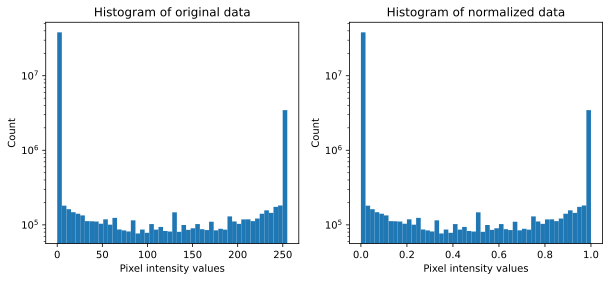

In [9]:
# Plot the data to see the data distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(train_data.flatten(), 50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(train_data_norm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of normalized data")
ax[1].set_yscale("log")

plt.show()

In [10]:
### Create train and test groups using dataloader
# Convert to tensor
train_data_tensor = torch.tensor(train_data_norm).float()
train_labels_tensor = torch.tensor(train_labels).long()
test_data_tensor = torch.tensor(test_data_norm).float()
test_labels_tensor = torch.tensor(test_labels).long()

# Test and dev set split
dev_dataset, test_dataset, dev_label, test_label = train_test_split(
    test_data_tensor, test_labels_tensor, test_size=0.5
)

# Convert into pytorch dataset
train_dataT = TensorDataset(train_data_tensor, train_labels_tensor)
dev_dataT = TensorDataset(dev_dataset, dev_label)
test_dataT = TensorDataset(test_dataset, test_label)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
devset_loader = DataLoader(
    dev_dataT,
    batch_size=dev_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)
testset_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [11]:
# To check all the variables in the workspace
%whos

Variable              Type             Data/Info
------------------------------------------------
DataLoader            type             <class 'torch.utils.data.dataloader.DataLoader'>
F                     module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset         type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                    ndarray          2: 2 elems, type `object`, 16 bytes
backend_inline        module           <module 'matplotlib_inlin<...>nline/backend_inline.py'>
batchsize             int              32
dev_dataT             TensorDataset    <torch.utils.data.dataset<...>object at 0x7fe59412cf80>
dev_dataset           Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
dev_label             Tensor           tensor([1, 4, 5,  ..., 4, 3, 4])
device                device           cpu
devset_loader         DataLoader       <torch.utils.data.dataloa<...>object at 0x7fe59862f2c0>
display            

In [12]:
# Create the model function
def createNewMNISTNet(lr=0.01):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784, 128)

            # Hidden Layers
            self.hidden1 = nn.Linear(128, 256)
            self.hidden2 = nn.Linear(256, 256)
            self.hidden3 = nn.Linear(256, 128)
            self.hidden4 = nn.Linear(128, 32)

            # Output Layer
            self.output = nn.Linear(32, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            x = F.relu(self.hidden3(x))
            x = F.relu(self.hidden4(x))
            return torch.log_softmax(self.output(x), axis=1)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.NLLLoss()
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, lossFun, optimizer

In [13]:
# Test the model
net, lossFun, optimizer = createNewMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

loss = lossFun(yHat, y)

print(f"Loss: {loss}")
print(yHat)

Loss: 2.3209164142608643
tensor([[-2.3166, -2.4114, -2.3465, -2.2230, -2.2621, -2.4000, -2.2660, -2.0959,
         -2.3603, -2.3883],
        [-2.3165, -2.4125, -2.3464, -2.2236, -2.2627, -2.4008, -2.2650, -2.0961,
         -2.3604, -2.3860],
        [-2.3148, -2.4116, -2.3465, -2.2231, -2.2629, -2.4013, -2.2644, -2.0966,
         -2.3609, -2.3879],
        [-2.3163, -2.4114, -2.3458, -2.2239, -2.2621, -2.4008, -2.2633, -2.0967,
         -2.3616, -2.3881],
        [-2.3142, -2.4122, -2.3463, -2.2247, -2.2629, -2.4007, -2.2630, -2.0959,
         -2.3615, -2.3888],
        [-2.3166, -2.4113, -2.3464, -2.2238, -2.2617, -2.3993, -2.2648, -2.0964,
         -2.3614, -2.3883],
        [-2.3143, -2.4120, -2.3459, -2.2230, -2.2633, -2.3996, -2.2669, -2.0957,
         -2.3599, -2.3895],
        [-2.3133, -2.4125, -2.3481, -2.2250, -2.2624, -2.4001, -2.2633, -2.0955,
         -2.3618, -2.3882],
        [-2.3144, -2.4117, -2.3468, -2.2241, -2.2639, -2.3992, -2.2666, -2.0954,
         -2.3594, -2.3

In [14]:
# Function to train the model
nEpochs = 30


def trainTheModel():
    net, lossFun, optimizer = createNewMNISTNet(lr=0.005)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    devAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(devset_loader))
        with torch.no_grad():
            yHat = net(X)

        devAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu())
    # End of epoch

    return trainAcc, devAcc, losses, net

In [15]:
trainAcc, devAcc, losses, net = trainTheModel()

In [16]:
# Function to check the test Accuracy
def testModePerformance(dataset):
    testAcc = []
    # Model in evaluation mode
    net.eval()

    for X, y in dataset:
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100 * (torch.argmax(yHat, axis=1) == y).float().cpu())

    return testAcc


testAcc = testModePerformance(testset_loader)

In [17]:
print(f"Train Accuracy is : {trainAcc[-1]}")
print(f"Dev Accuracy is : {devAcc[-1]}")
print(f"Test Accuracy is : {np.mean(testAcc)}")
print(len(testAcc), len(devAcc))
print(np.array(testAcc[0].detach()).shape)

Train Accuracy is : 94.66166687011719
Dev Accuracy is : 85.63999938964844
Test Accuracy is : 85.41999816894531
1 30
(5000,)


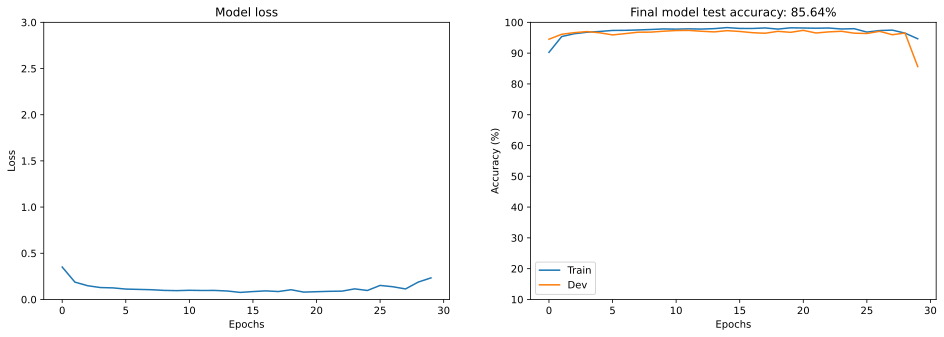

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(devAcc, label="Dev")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {devAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [19]:
# run the model through for the test data
X, y = next(iter(testset_loader))
predictions = net(X).detach()

predictions

tensor([[-3.9096e+00, -4.9026e+00, -4.1961e+00,  ..., -4.4655e+00,
         -3.7250e+00, -3.2499e+00],
        [-5.8332e+00, -1.6281e-01, -4.1931e+00,  ..., -4.2604e+00,
         -2.7933e+00, -4.0349e+00],
        [-1.4112e+01, -1.9074e+01, -2.5470e+01,  ..., -4.1190e+01,
         -2.9802e-06, -3.0746e+01],
        ...,
        [-1.4275e+03, -6.5720e+02, -7.4794e+02,  ..., -7.7666e+02,
         -2.2497e+02, -7.7563e+02],
        [-4.7890e+01, -4.9458e+01,  0.0000e+00,  ..., -3.7436e+01,
         -6.1933e+01, -1.0622e+02],
        [-3.9096e+00, -4.9026e+00, -4.1961e+00,  ..., -4.4655e+00,
         -3.7250e+00, -3.2499e+00]])

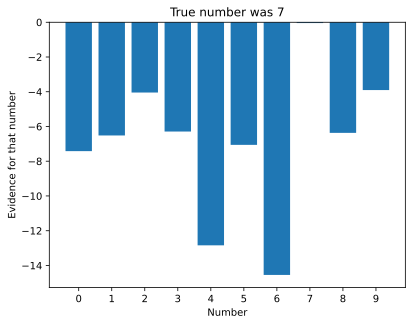

In [20]:
# Evidence for all numbers from one sample
sample2show = 122

plt.bar(range(10), predictions[sample2show].cpu())  # try adding exp!
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence for that number")
plt.title("True number was %s" % y[sample2show].item())
plt.show()

[   3   15   18   24   28   32   41   43   48   50   62   64   69   79
   82   85   88   92   93   94  101  105  127  136  141  142  155  161
  165  177  181  186  199  209  220  221  224  233  256  257  269  276
  292  293  298  323  330  332  348  372  375  387  389  391  392  399
  400  404  408  412  413  421  422  428  436  446  467  469  475  486
  489  490  493  494  497  500  504  525  528  532  552  570  571  574
  578  583  586  599  605  610  623  626  629  630  631  632  633  653
  656  658  673  680  688  690  707  708  713  715  720  727  734  736
  739  743  762  777  787  804  808  810  812  814  826  836  837  842
  848  849  858  867  903  905  913  915  921  922  932  938  948  955
  973  977  983  993  994 1010 1017 1019 1020 1028 1029 1033 1045 1050
 1069 1099 1102 1105 1114 1118 1139 1145 1147 1166 1168 1170 1172 1174
 1176 1184 1185 1187 1196 1208 1212 1223 1244 1250 1254 1267 1268 1269
 1272 1279 1280 1282 1288 1291 1292 1303 1314 1336 1338 1348 1359 1361
 1365 

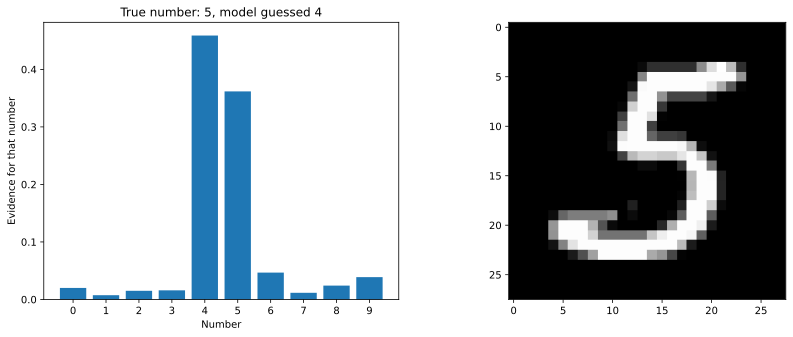

In [21]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1].cpu() != y.cpu())[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 11

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]].cpu()))
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("Evidence for that number")
ax[0].set_title(
    "True number: %s, model guessed %s"
    % (
        y[errors[sample2show]].cpu().item(),
        torch.argmax(predictions[errors[sample2show]]).cpu().item(),
    )
)

ax[1].imshow(np.reshape(X[errors[sample2show], :].cpu(), (28, 28)), cmap="gray")

plt.show()

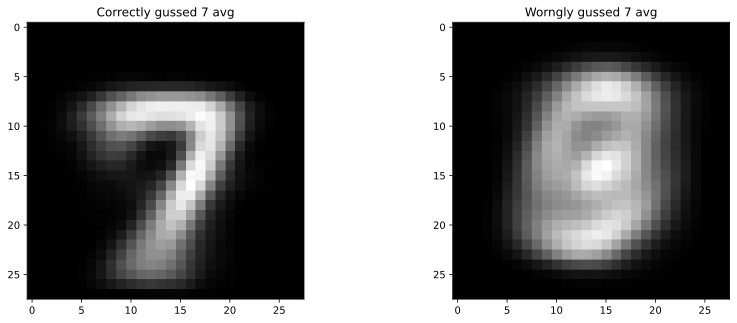

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?

X, y = next(iter(testset_loader))
sevenIdxs = np.where(y.cpu() == 7)[0]
y_seven = y[sevenIdxs].cpu()
predictions = net(X).cpu().detach()

seven_errors_Idx = np.where(torch.max(predictions, axis=1)[1].cpu() != 7)
seven_corr_Idx = np.where(torch.max(predictions, axis=1)[1].cpu() == 7)
seven_err = torch.mean(X[seven_errors_Idx], axis=0).reshape(28, 28)
seven_corr = torch.mean(X[seven_corr_Idx], axis=0).reshape(28, 28)

# Plot the result

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].imshow(seven_corr.cpu(), cmap="gray")
ax[0].set_title("Correctly gussed 7 avg")
ax[1].imshow(seven_err.cpu(), cmap="gray")
ax[1].set_title("Worngly gussed 7 avg")

plt.show()

In [ ]:

# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
#
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
#
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
#